### Описание проекта
Нам передали данные сервиса проката электросамокатов GoFast

Данные сожержат информацию о  пользователях из нескольких городов, а также об их поездках. 
Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
**без подписки**
абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;
**с подпиской Ultra**
абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import math
from math import sqrt
from scipy import stats as st
from scipy.stats import binom, norm
pd.options.display.max_columns = 20

#### Шаг 1. Загрузка данных

In [2]:
# 1.1 Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы.
users_go = pd.read_csv('/datasets/users_go.csv')  
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
#1.2 Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.
for df in [users_go, rides_go, subscriptions_go]:
    display(df.head(10))
    df.info()
    display(df.describe())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


**Датасет о пользователях сервиса**
* содержит 1565 строк
* в первичных строках данные выглядят корректно

**Датасет о поездках ползователей**
* содержит 18068 строк
* тип столбца с датой object
* время и дистанции поездок имеются с малыми значениями, возможно есть аномалии-выбросы, а также большое количество знаков после запятой

**Датасет о подписках**
* содержит 2 строки собственно потому что 2 вида подписки
* в первичных строках данные выглядят корректно


#### Шаг 2. Предобработка данных

**Рассмотрим количество пропусков в таблицах**


In [4]:
#Таблица с пользователями
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [5]:
#Таблица с поездками
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [6]:
#Таблица с подписками
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Рассмотрим столбцы и поменяем тип данных там, где это возможно**

In [7]:
#Приведем столбец date в датасете rides_go к типу даты pandas.
rides_go['date'] = pd.to_datetime(rides_go['date'], format = '%Y-%m-%d')

In [8]:
rides_go['date'].head(10)

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
5   2021-10-09
6   2021-10-19
7   2021-11-06
8   2021-11-14
9   2021-11-22
Name: date, dtype: datetime64[ns]

**Создайте новый столбец с номером месяца на основе столбца date.**

In [9]:
#проверим, за какой период предоставлены данные. Если данные предоставлены за несколько лет, то они могут попасть в один и тот же месяц
rides_go['date'].dt.year.unique()

array([2021])

In [10]:
#Данные предоставлены только за один год, соответственно ошибок не будет, добавим номер месяца:
rides_go['month'] = rides_go['date'].dt.month
rides_go['month'].head(10)

0     1
1     1
2     4
3     8
4     8
5    10
6    10
7    11
8    11
9    11
Name: month, dtype: int64

**Обработаем дубликаты если имеются**

In [11]:
#Таблица с пользователями
users_go.duplicated().sum()

31

In [12]:
users_go.drop_duplicates(inplace=True)
users_go.duplicated().sum()

0

In [13]:
#Таблица с поездками
rides_go.duplicated().sum()

0

**Вывод:**

Итоги предобработки:

* Пропущенных данных в таблицах нет.
* Дубликаты имеются среди пользователей, удалили строки-дубликаты.
* Добавили столбец month с номер месяца.
* Привели столбец date в датасете rides_go к типу даты pandas

#### Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:

**Частота встречаемости городов**

In [14]:
count_users_by_city = users_go['city'].value_counts()
count_users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

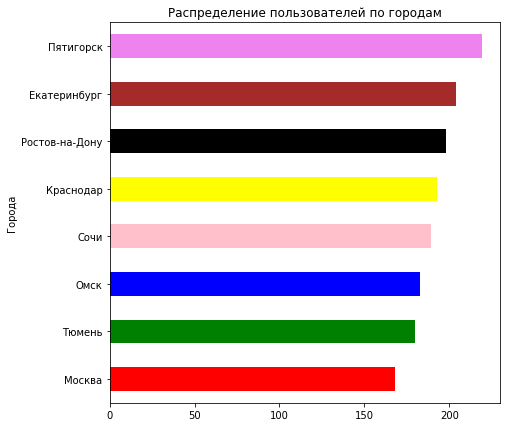

In [15]:
users_go['city'].value_counts(ascending=True).plot.barh(
    xlabel = 'Города', 
    ylabel = 'Количество пользователей',
    figsize = (7,7),
    color = ["red", "green", "blue", "pink", "yellow", "black", "brown", "violet"],
    title = 'Распределение пользователей по городам')
plt.show()

ТОП-3 городов по пользователям:
* Пятигорск         219
* Екатеринбург      204
* Ростов-на-Дону    198


меньше всего в Москве - 168

Пятигорск по размерам в несколько раз меньше Москвы (в Пятигорске удобнее брать самокат, чтобы куда-то добраться) и там достаточно теплый климат большую часть года, подходящий для поездок.

**Соотношение пользователей с подпиской и без подписки**

In [16]:
users_go['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

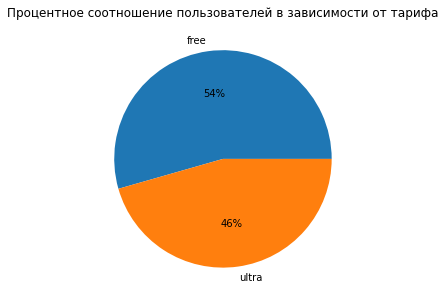

In [17]:
users_go['subscription_type'].value_counts().plot.pie(
    autopct = '%1.0f%%', 
    figsize = (5,5),
    title = 'Процентное соотношение пользователей в зависимости от тарифа')
plt.ylabel(None)
plt.show()

Подпиской пользуется 46% пользователей, без нее - 54%

**Возраст пользователей**

In [18]:
#Самые младшие пользователи
users_go['age'].sort_values().head(10)

664     12
66      12
727     12
34      12
235     13
1249    13
314     13
83      13
553     13
1241    13
Name: age, dtype: int64

In [19]:
#Самые старшие пользователи
users_go['age'].sort_values(ascending=False).head(10)

1201    43
961     39
804     38
453     38
383     38
205     37
848     37
721     36
1491    36
644     36
Name: age, dtype: int64

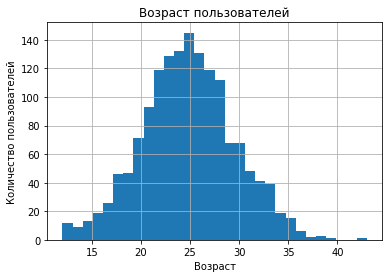

In [20]:
plt.hist(users_go['age'], bins = 30)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

In [21]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Примерно можно разделить на 5 групп. В лидерах группа от 23 до 26 лет. Примечательно что самые маленькие 12-16 лет и самые взрослые 37-43 - в группе где количество небольшое.
* средний возраст 25 лет
* мин 12
* макс - 43

**Расстояние, которое пользователь преодолел за одну поездку**

In [22]:
#Самые короткие дистанции за одну поездку:
rides_go['distance'].sort_values().head(10)

11555     0.855683
9541      2.570787
13690     4.329506
8658      6.784447
7841      7.097072
8906     11.283615
8324     12.233115
13940    15.000606
15626    15.366168
11862    15.630873
Name: distance, dtype: float64

In [23]:
#Самые длинные дистанции за одну поездку:
rides_go['distance'].sort_values(ascending=False).head(10)

16309    7211.007745
16484    7066.003772
15580    6908.491343
17171    6760.940067
17242    6724.932981
10341    6671.969833
11385    6601.197575
12086    6538.937375
10915    6535.386520
11319    6503.600402
Name: distance, dtype: float64

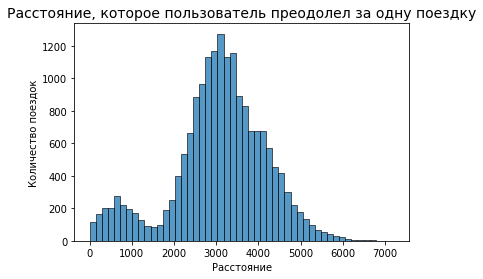

In [24]:
sns.histplot(rides_go['distance'], bins = 50)
plt.title("Расстояние, которое пользователь преодолел за одну поездку", size=14)
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

In [25]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

**Итого**
* Среднее - 3070 м
* мин - менее метра
* макс - более 7211 км

Думаю целесообразен акцент на СРЕДНЕМ для самокатов-поездок, чем на медиане

**Продолжительность поездок**

In [26]:
#Самые короткие поездки:
rides_go['duration'].sort_values().head(10)

12013    0.5
17314    0.5
15029    0.5
7437     0.5
12967    0.5
15015    0.5
13012    0.5
7508     0.5
16589    0.5
9049     0.5
Name: duration, dtype: float64

In [27]:
#Самые долгие поездки:
rides_go['duration'].sort_values(ascending=False).head(10)

4215    40.823963
4709    39.873856
2623    39.526602
1998    38.352763
6453    38.265229
143     38.125729
3729    37.014141
499     36.906491
6348    36.809310
4653    36.622595
Name: duration, dtype: float64

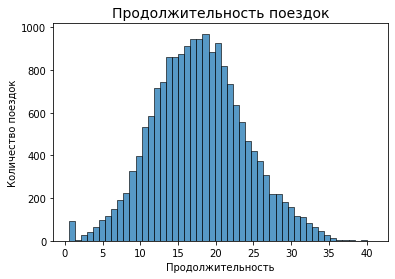

In [28]:
sns.histplot(rides_go['duration'], bins = 50)
plt.title("Продолжительность поездок", size=14)
plt.xlabel('Продолжительность')
plt.ylabel('Количество поездок')
plt.show()

In [29]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

**Итого:**
* минимальное время пол минуты
* среднее  - 17,8 минут
* максимум - 40,82 минут

#### Шаг 4. Объединение данных

**Объединим данные о пользователях, поездках и подписках в один датафрейм:**

In [30]:
full_data = users_go.merge(rides_go)
full_data = full_data.merge(subscriptions_go)
full_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [31]:
#кратко рассмотрим ультра короткие поездки
full_data[(full_data['duration']<2)]['duration'].count()

95

In [32]:
full_data.query('duration < 2')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6531,701,Иван,31,Екатеринбург,free,4196.445201,0.5,2021-08-31,8,8,50,0
6570,704,Мирон,29,Ростов-на-Дону,free,4830.824371,0.5,2021-10-14,10,8,50,0
6680,712,Дарья,28,Москва,free,4684.004397,0.5,2021-03-04,3,8,50,0
6695,713,Святослав,30,Краснодар,free,5215.642710,0.5,2021-02-25,2,8,50,0
6768,718,Владислава,31,Москва,free,5197.436649,0.5,2021-02-11,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17004,1460,Жанна,27,Пятигорск,free,5531.335845,0.5,2021-01-19,1,8,50,0
17242,1477,Ян,17,Сочи,free,6724.932981,0.5,2021-01-12,1,8,50,0
17314,1483,Роберт,26,Екатеринбург,free,4445.481070,0.5,2021-03-06,3,8,50,0
17505,1496,Яна,19,Москва,free,5722.551787,0.5,2021-02-14,2,8,50,0


In [33]:
full_data[(full_data['distance']<2)]['distance'].count()

1

In [34]:
full_data.query('distance < 2')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
11555,1069,Степан,20,Сочи,free,0.855683,10.001902,2021-01-31,1,8,50,0


Получается что из-за тех.ошибки есть 95 поездок менее 2 мин (чаще всего 0.5 мин), но с большим расстоянием которое нельзя проехать за такое время (т.к. учет времени не велся то за него и не заплатили - возможно рекламная или пром поездка). Сообщим о проблеме сервису в выводах. по длине 1 поездка которая реалистична.

**Создадим датафрейм с данными о пользователях без подписки:**

In [35]:
free_sub = full_data.query("`subscription_type` == 'free'")
free_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


**Визуализируем информацию о расстоянии на бесплатной подписке:**

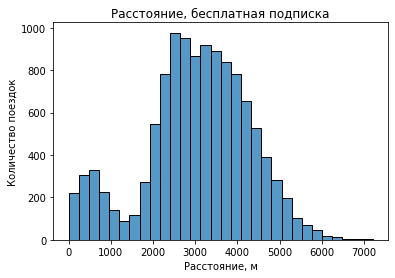

<Figure size 1440x1440 with 0 Axes>

In [36]:
sns.histplot(free_sub['distance'], bins=30)
plt.title('Расстояние, бесплатная подписка')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

In [37]:
free_sub['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

* среднее 3045 м
* мин - менее метра
* макс - 7211 м

**Визуализируем информацию о времени на бесплатной подписке:**

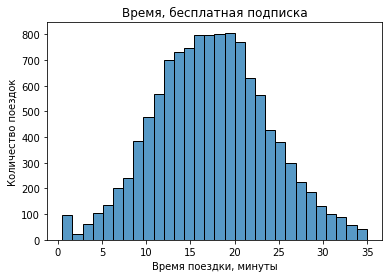

<Figure size 1440x1440 with 0 Axes>

In [38]:
sns.histplot(free_sub['duration'], bins=30)
plt.title('Время, бесплатная подписка')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

In [39]:
free_sub['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

* среднее время - 17,3 мин
* мин- пол минуты
* макс - 35 мин

**Создадим датафрейм с данными о пользователях с подпиской:**

In [40]:
ultra_sub = full_data.query("`subscription_type` == 'ultra'")
ultra_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


**Визуализируем информацию о расстоянии на платном тарифе:**

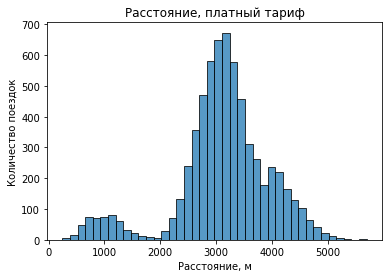

<Figure size 1440x1440 with 0 Axes>

In [41]:
sns.histplot(ultra_sub['distance'], bins=40)
plt.title('Расстояние, платный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

In [42]:
ultra_sub['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

* среднее 3115 м
* мин - 244 м
* макс - 5699 м

**Визуализируем информацию о времени на платном тарифе:**

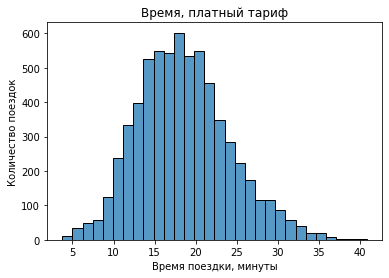

<Figure size 1440x1440 with 0 Axes>

In [43]:
sns.histplot(ultra_sub['duration'], bins=30)
plt.title('Время, платный тариф')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

In [44]:
ultra_sub['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

* среднее - 18,5 мин
* мин - 3,76 мин
* макс - 40,8 мин

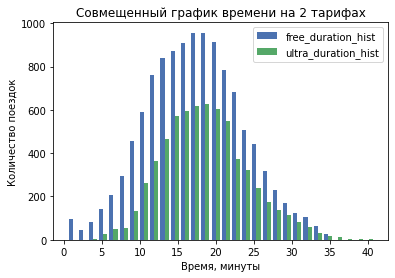

In [45]:
plt.style.use('seaborn-deep')
x = free_sub['duration']
y = ultra_sub['duration']

bins = 30

plt.hist([x, y], bins, label=['free_duration_hist', 'ultra_duration_hist'])
plt.legend(loc='upper right')
plt.xlabel('Время, минуты')
plt.ylabel('Количество поездок')
plt.title('Совмещенный график времени на 2 тарифах')
plt.show()

На бесплатной подписке больше количество продолжительных поездок.

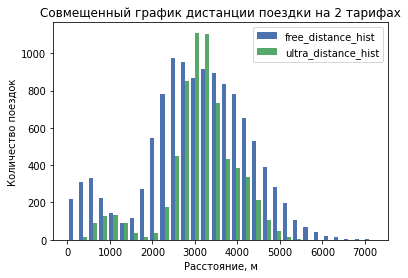

In [46]:
plt.style.use('seaborn-deep')
x = free_sub['distance']
y = ultra_sub['distance']

bins = 30

plt.hist([x, y], bins, label=['free_distance_hist', 'ultra_distance_hist'])
plt.legend(loc='upper right')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.title('Совмещенный график дистанции поездки на 2 тарифах')
plt.show()

на бесплатной подписке больше количество более длинных по расстоянию поездок.Но в районе 3 км пользователи с платной подпиской совершают больше поездок.

**Выводы:**

* Объединили данные о пользователях, поездках и тарифах в один датафрейм - full_data.

* Выделили два датафрейма на основе full_data:

  free_sub - Информация о пользователях с бесплатным тарифом
  
  ultra_sub - Информация о пользователях с платным тарифом
  
  

* Визуализировали информацию о расстоянии и времени для каждого из тарифов.


* Интересная ситуация на обоих тарифах около 1 км - предположу что это тестовые заезды в беплатном / экономия денег на платном (до магазина и т.п.)

В данном случае радикальных отличий в характеристиках показателей пользователей платной и бесплатной подписке я не наблюдаю, кроме того что на бесплатной больше проезжают длинные расстояния чаще. Самая длинная поездка на бесплатной подписке - более 7 км.

#### Шаг 5. Подсчёт выручки

**Найдем суммарное расстояние, количество поeздок и суммарное время для каждого пользователя за каждый месяц**

In [47]:
#округлим продолжительность до целых чисел
full_data['duration'] = np.ceil(full_data['duration'])

In [48]:
total_data = pd.pivot_table(full_data,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min})

In [49]:
total_data.rename(columns = {'name' : 'count_tips'}, inplace = True)

In [50]:
total_data.sort_values(by='month').head(20)

distance  duration  count_tips subscription_type
month user_id                                                      
1     1         7027.511294      42.0           2             ultra
      1061     12637.249630      43.0           3              free
      1063      3276.362299      10.0           1              free
      1064      5297.324649      15.0           1              free
      1065     14547.099333      99.0           4              free
      1066      2809.064949      19.0           1              free
      1067      3864.900780      22.0           1              free
      1069      7007.076943      53.0           3              free
      1071      3635.094136      15.0           1              free
      1072      2498.615999      11.0           1              free
      1073      2945.802455      16.0           1              free
      1074      2814.793386      22.0           1              free
      1075      5746.745124      29.0           3              free
      1077       114.036199      13.0           1              free
      1078      3748.219563      19.0           1              free
      1082      7250.124895      30.0           2              free
      1083      5848.881463      31.0           2              free
      1084      4615.097141      25.0           1              free
      1085     11410.546346      63.0           3              free
      1086      4044.280322      18.0           1              free

In [51]:
total_data.query('user_id == 1')

,,distance,duration,count_tips,subscription_type
month,user_id,,,,
1,1,7027.511294,42.0,2,ultra
4,1,754.159807,7.0,1,ultra
8,1,6723.470560,46.0,2,ultra
10,1,5809.911100,32.0,2,ultra
11,1,7003.499363,56.0,3,ultra
12,1,6751.629942,28.0,2,ultra


**Добавим столбец с помесячной выручкой**

**без подписки**
* абонентская плата отсутствует;
* стоимость одной минуты поездки — 8 рублей;
* стоимость старта (начала поездки) — 50 рублей;

**с подпиской Ultra**
* абонентская плата — 199 рублей в месяц;
* стоимость одной минуты поездки — 6 рублей;
* стоимость старта — бесплатно.

In [52]:
#Помесячная выручка считается по формуле: 
#по формуле: (стоимость старта поездки ×  количество поездок) + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах) + стоимость подписки.
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['count_tips']
    else:
        return 'Нет данных о подписке'

In [53]:
total_data['revenue_per_month'] = total_data.apply(revenue, axis=1)

In [54]:
total_data['revenue_per_month'].head(20)

month  user_id
1      1          451.0
       3          277.0
       5          277.0
       7          367.0
       12         397.0
       13         451.0
       14         409.0
       15         433.0
       20         373.0
       22         277.0
       25         301.0
       26         367.0
       30         349.0
       32         349.0
       35         541.0
       42         337.0
       43         487.0
       44         313.0
       45         361.0
       46         319.0
Name: revenue_per_month, dtype: float64

In [55]:
total_data.query('user_id == 1')

,,distance,duration,count_tips,subscription_type,revenue_per_month
month,user_id,,,,,
1,1,7027.511294,42.0,2,ultra,451.0
4,1,754.159807,7.0,1,ultra,241.0
8,1,6723.470560,46.0,2,ultra,475.0
10,1,5809.911100,32.0,2,ultra,391.0
11,1,7003.499363,56.0,3,ultra,535.0
12,1,6751.629942,28.0,2,ultra,367.0


**Вывод**

Создали новый датафрейм с агрегированными данными (total_data) на основе датафрейма с объединенными данными (full_data).

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также добавили столбец с помесячной выручкой, которую принес каждый пользователь.

#### Шаг 6. Проверка гипотез

**Гипотеза 1: Пользователи с подпиской тратят больше времени на поездки.**
Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу используя исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Предположим, что:

    H_0: Время (duration) пользователей на подписке ultra = время (duration) пользователей на подписке free
    H_1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

Статистическая значимость - alpha = 0.05

In [56]:
ultra = ultra_sub['duration'] 

free = free_sub['duration']

results = st.ttest_ind(ultra, 
                       free,
                       alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [57]:
ultra.mean()

18.54198516280583

In [58]:
free.mean()

17.39090929866399

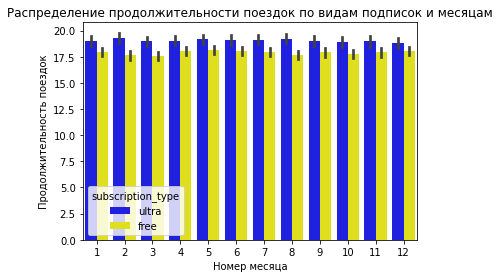

In [59]:
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = full_data,
            palette = ['blue', 'yellow'])
ax.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');

**Вывод**
Проверили гипотезу, отвергли гипотезу о том, что время поездки пользователей на тарифе ultra равно времени поездки пользователей на тарифе free.
Пользователи с подпиской в пути проводят больше времени.

**Гипотеза 2:** Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. (Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.)

H_0: Расстояние (distance) пользователей на подписке ultra = 3130 метров

H_1: Расстояние (distance) пользователей на подписке ultra > 3130 метров

alpha = 0.05

In [60]:
ultra_dist = ultra_sub['distance']

interested_value = 3130.0

alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


**Вывод**

Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra не превышает 3130 метров = расстояние принципиально не отличается от 3130 м

**Гипотеза 3:** помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

H_0: Выручка (revenue_per_month) пользователей на подписке ultra = выручка (revenue_per_month) пользователей на подписке free

H_1: Выручка (revenue_per_month) пользователей на подписке ultra > выручка (revenue_per_month) пользователей на подписке free

alpha = 0.05

In [61]:
ultra_per_month = total_data.loc[total_data.subscription_type == 'ultra', 'revenue_per_month'] 

free_per_month = total_data.loc[total_data.subscription_type == 'free', 'revenue_per_month'] 


results = st.ttest_ind(ultra_per_month, 
                       free_per_month,
                       alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [62]:
ultra_per_month.mean()

362.7921906022502

In [63]:
free_per_month.mean()

328.6413651073845

**Вывод**

Проверили гипотезу, соответственно, мы можем утверждать, что выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free

**Гипотеза 4:** техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:

H0 : μ1 = μ2

H1 : μ1 > μ2
где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: **scipy.stats.ttest_rel()**

#### Шаг 7. Распределения (доп.задания)

**7.1.** Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей.
Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%
Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [64]:
# задаём параметры биномиального распределения
n = 0
p = 0.1
k = 99

# используем cdf который вернет нам значени n
while st.binom.cdf(k,n,p)>=0.05:
    n+=1
else:
    print('min количество промокодов с вероятностью 5% не выполнить план составляет: ', n)

min количество промокодов с вероятностью 5% не выполнить план составляет:  1161


**7.2.** Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 
1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [65]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


Вероятность что откроют не более 399,5 тысяч писем из рассылки составляет чуть более 15%.

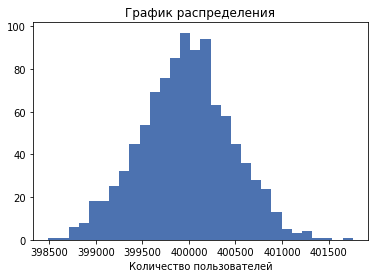

In [66]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

s = np.random.normal(mu, sigma, 1000) # генерируем значения для нормального распределения


plt.hist(s, 30) # строим гистограмму
plt.title('График распределения')
plt.xlabel('Количество пользователей')

plt.show()

**Итоговый вывод:**

Получили для анализа 3 датафрейма: с пользователями, информацией о поездках, информацией о подписках.


**Прдобработка данных**
* Проверили данные на пропуски, их не оказалось ни в одной таблице
* Пропущенных данных в таблицах не было.
* Дубликаты имелись среди пользователей, удалили строки-дубликаты.
* Добавили столбец month с номер месяца.
* Привели столбец date в датасете rides_go к типу даты pandas


**Исследовательский анализ данных:**

**Выводы по пользователям на обоих подписках:**

Вывели, что количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168.
Пользователей, использующих бесплатную подписку больше - 835 человек, что является ~54% от общего числа пользователей. На платной подписке сидит 699 пользователей, что соответственно является ~46%.

**Возраст пользователей:**

Примерно можно разделить на 5 групп. В лидерах группа от 23 до 26 лет. Примечательно что самые маленькие 12-16 лет и самые взрослые 37-43 - взрослая группа небольшая.
* средний возраст 25 лет
* мин 12
* макс - 43

**Дистанция поездок:**

* Среднее - 3070 м
* мин - менее метра
* макс - более 7211 км

**Время поездок:**

* минимальное время пол минуты
* среднее - 17,8 минут
* максимум - 40,82 минут

**Обнаружено что из-за тех.ошибки есть 95 поездок менее 2 мин (чаще всего 0.5 мин), но с большим расстоянием которое нельзя проехать за такое время. Т.к. учет времени не велся то за него и не заплатили - возможно рекламная или пром поездка.
Сервису необходимо обратить внимание!**

**Объединили данные о пользователях, поездках и подписках в один датафрейм. На основе объединенного датафрейма создали еще 2 датафрейма:**

* Для пользователей с ultra подпиской
* Для пользователей с free подпиской

Дальше визуализировали информацию о расстоянии и времени поездки для пользоватей каждого тарифа.

**Бесплатная подписка.** 

Расстояние:
* среднее 3045 м
* мин - менее метра
* макс - 7211 м

Время:
* среднее время - 17,3 мин
* мин- пол минуты
* макс - 35 мин

**Платная подписка.** 

Расстояние:
* среднее 3115 м
* мин - 244 м
* макс - 5699 м

Время:
* среднее - 18,5 мин
* мин - 3,76 мин
* макс - 40,8 мин


**Сравнительно две подписки:**
* На бесплатной подписке больше количество продолжительных поездок.
* На бесплатной подписке больше количество более длинных по расстоянию поездок.Но в районе 3 км пользователи с платной подпиской совершают больше поездок.
* Самая длинная по расстоянию поездка на бесплатной подписке - более 7 км.
* Самая продолжительная по времение на платной подписке - 40,8 мин
* Интересный ПИК на обоих подписках около 1 км - предположу что это тестовые заезды / экономия денег  (до магазина и т.п.)
* средняя выручка в месяц на платной - 362,79 руб , на бесплатной - 328,64


Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датафрейм total_data. Добавили в датафрейм total_data столбец с помесячной выручкой revenue_per_month.

**Проверили гипотезы:**

Пользователи с платной подпиской тратят больше времени на поездки, чем пользователи на бесплатной подписке

**Отвергли нулевую гипотезу**

Пользователи с платной подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку 

**Не удалось отвергнуть нулевую гипотезу**

Помесячная выручка от пользователей с платной подпиской выше, чем выручка от пользователей без подписки

**Отвергли нулевую гипотезу**